## Diffusion Algorithms

This notebook is meant to explore the fundamental of diffusion models before actually training the diffusion model

In [2]:
import os
import math
from abc import abstractmethod

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from PIL import Image
import requests
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

import nibabel as nib
import monai
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Compose,
    RandScaleCrop,
    RandFlip,
    RandRotate90,
    RandRotate,
    RandShiftIntensity,
    ToTensor,
    RandSpatialCrop,
    LoadImage,
    SqueezeDim,
    RandRotate,
    RandShiftIntensity
)

import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

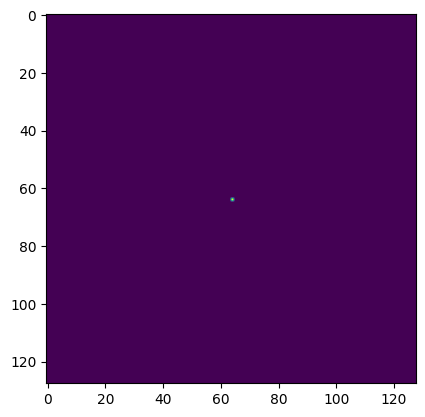

torch.Size([1, 3, 128, 128, 128])


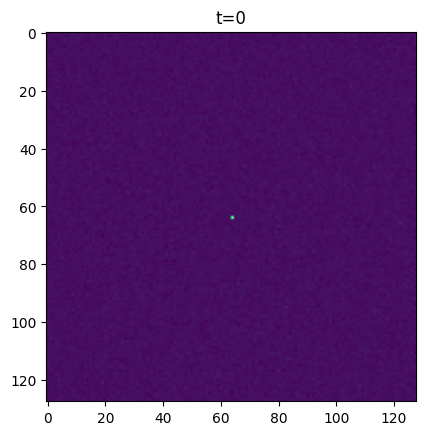

torch.Size([1, 3, 128, 128, 128])


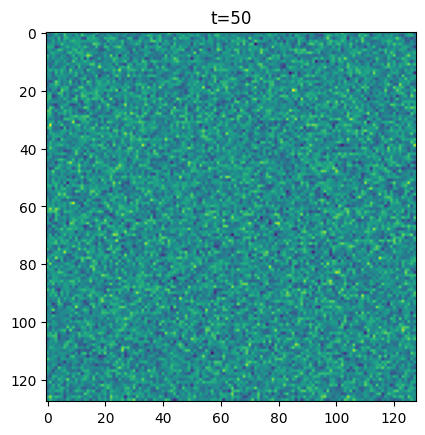

torch.Size([1, 3, 128, 128, 128])


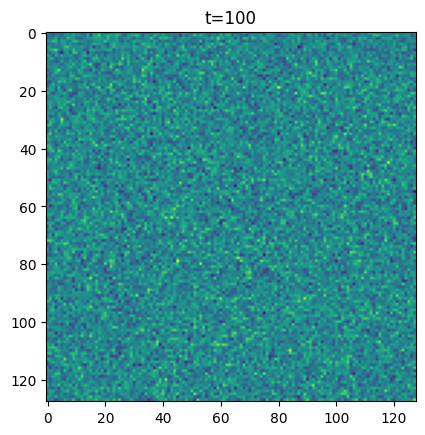

torch.Size([1, 3, 128, 128, 128])


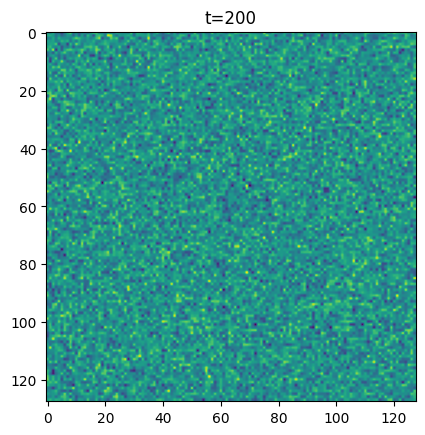

torch.Size([1, 3, 128, 128, 128])


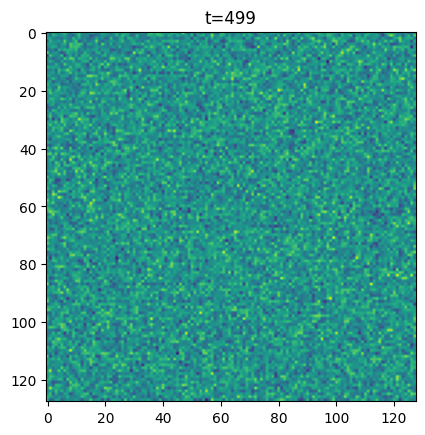

In [3]:
def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    Args:
        timesteps (Tensor): a 1-D Tensor of N indices, one per batch element. These may be fractional.
        dim (int): the dimension of the output.
        max_period (int, optional): controls the minimum frequency of the embeddings. Defaults to 10000.

    Returns:
        Tensor: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, t):
        """
        Apply the module to `x` given `t` timestep embeddings.
        """
        pass


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that support it as an extra input.
    """

    def forward(self, x, t):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, t)
            else:
                x = layer(x)
        return x


def norm_layer(channels):
    return nn.GroupNorm(32, channels)


class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        )

        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        t_emb = self.time_emb(t)
        h += t_emb[:, :, None, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        """
        Attention block with shortcut

        Args:
            channels (int): channels
            num_heads (int, optional): attention heads. Defaults to 1.
        """
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv3d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv3d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, D, H, W= x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, D*H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, D, H, W)
        h = self.proj(h)
        return h + x


class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv3d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv3d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool3d(stride=2)

    def forward(self, x):
        return self.op(x)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding
    """
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv3d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )

        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv3d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """Apply the model to an input batch.

        Args:
            x (Tensor): [N x C x H x W]
            timesteps (Tensor): a 1-D batch of timesteps.

        Returns:
            Tensor: [N x C x ...]
        """
        hs = []
        # time step embedding
        print('Time step embed')
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        # down stage
        h = x
        print('modules begin')
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        print('middle stage')
        h = self.middle_block(h, emb)
        # up stage
        print('up stage')
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)


def linear_beta_schedule(timesteps, start_scale=0.0001, end_scale=0.02):
    """
    beta schedule
    """
    ###############################################################
    # [TASK] complete following section:
    # to compute : linear beta schedule
    #
    # should be a linear beta between start_scale to end_scale
    ###############################################################
    return  torch.linspace(start_scale, end_scale, timesteps)

    ###############################################################


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    """
    ###############################################################
    # [extra TASK] complete following section:
    # to compute : cosine beta schedule
    #
    #
    # should be a cosine beta between start_scale to end_scale
    # hint, check out paper: in https://arxiv.org/abs/2102.09672
    ###############################################################
    t = torch.arange(0, timesteps+1)
    f0 = np.cos(1/(1+s)*np.pi/2)**2
    alpha_t = np.cos((t/t[-1]+1)/(1+s)*np.pi/2)**2 / f0
    return 1 - (alpha_t / (alpha_t - 1))

    ###############################################################


class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))

        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )

    def _extract(self, a, t, x_shape):
        # get the param of given timestep t
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self, x_start, t, noise=None):
        # forward diffusion (using the nice property): q(x_t | x_0)
        if noise is None:
            noise = torch.randn_like(x_start)

        ###############################################################
        # [TASK] complete following section:
        # to compute : sqrt_alphas_cumprod_t
        #              sqrt_one_minus_alphas_cumprod_t
        #
        # and finish the noise blending from x_start (i.e., x_0) to x_t
        ###############################################################
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        x_t = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
        return x_t
        ###############################################################

    def q_mean_variance(self, x_start, t):
        # Get the mean and variance of q(x_t | x_0).
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def predict_start_from_noise(self, x_t, t, noise):
        # compute x_0 from x_t and pred noise: the reverse of `q_sample`
        ###############################################################
        # [TASK] complete me:
        # from x_t to x_0, Hint: Eq. 15 in DDPM
        ###############################################################
        x_0 = (x_t - self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * noise) / self._extract(self.sqrt_alphas_cumprod, t, x_t.shape)
        return x_0
        ###############################################################

    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # compute predicted mean and variance of p(x_{t-1} | x_t)
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        ###############################################################
        # [TASK] complete me:
        # model_mean, posterior_variance, posterior_log_variance
        # the predicted mean, variance and log variance of p(x_{t-1} | x_t)
        # do not forget to clip the denoised x_0 by
        # torch.clamp(x_reconstructed, min=-1., max=1.)
        # hint re-use q_posterior_mean_variance and predict_start_from_noise
        ###############################################################
        x_reconstructed = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_reconstructed = torch.clamp(x_reconstructed, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_reconstructed,x_t, t)
        ###############################################################

        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # denoise_step: sample x_{t-1} from x_t and pred_noise
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        # denoise: reverse diffusion
        batch_size = shape[0]
        device = next(model.parameters()).device
        ###############################################################
        # [TASK] complete me:
        # start from pure noise (for each example in the batch)
        # loop sample x_{t-1} from x_t
        # return the list of sampled images
        ###############################################################
        imgs = []
        x_t = torch.randn(*shape, device=device)
        for t in range(self.timesteps - 1, -1, -1):
            x_t = self.p_sample(model, x_t, torch.full((batch_size,), t, device=device))
            imgs.append(x_t)
        ###############################################################

        return imgs

    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        # sample new images
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

    def train_losses(self, model, x_start, t):
        """ compute train losses """
        # generate random noise
        noise = torch.randn_like(x_start)
        ###############################################################
        # [TASK] complete me:
        # 1. noised_x,
        # 2. predicted_noise,
        # 3. compare it with sampled noise
        ###############################################################
        noised_x = self.q_sample(x_start, t, noise)
        predicted_noise = model(noised_x, t)
        loss = F.mse_loss(predicted_noise, noise)        
        ##############################################################
        return loss



# x_start is a tensor of zeros shape [1, 3, 128, 128, 128] with ones on the diagonal
x_start = torch.zeros(1, 3, 128, 128, 128)
for i in range(128):
    x_start[0, :, i, i, i] = 1
plt.imshow(x_start[0, 0, 64])
plt.show()


gaussian_diffusion = GaussianDiffusion(timesteps=500)

for idx, t in enumerate([0, 50, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    print(x_noisy.shape)
    # display a 2D slice of the 3D volume
    plt.imshow(x_noisy[0, 0, 64])
    plt.title(f"t={t}")
    plt.show()






In [4]:
# define model and diffusion
timesteps = 500
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

print(device)

# test the untrained model on the diffusion process
x = torch.zeros(1, 1, 16, 16, 16)
for i in range(16):
    x[0, :, i, i, i] = 1

x = x.to(device)
t = torch.randint(0, timesteps, (x.shape[0],), device=device)
optimizer.zero_grad()
loss = gaussian_diffusion.train_losses(model, x, t)
print(loss)


cpu
Time step embed
modules begin
middle stage
up stage
tensor(1.0875, grad_fn=<MseLossBackward0>)


## Dataset

In [16]:
# this cell aims at extracting the list of path relevant for the first model test which takes T1w T2w adn DWI as image

base_dir="data//data-multi-subject//"

desired_extension = ".json"

# Initialize lists to store the relative paths for T1w, T2w, and DWI files
t1w_file_paths = []
t2w_file_paths = []

print("Searching for T1w, T2w, and DWI files in", base_dir, "...")

# Traverse the directory structure
for root, dirs, files in os.walk(base_dir):
    # Exclude the "derivatives" subfolder
    if "derivatives" in dirs:
        dirs.remove("derivatives")
    for file in files:
        # Check if the file name contains the desired names
        if "T1w" in file and file.endswith(desired_extension):
            # Get the relative path of the T1w file
            relative_path = os.path.relpath(os.path.join(root, file), base_dir)
            # Remove the file extension
            relative_path = os.path.splitext(base_dir + relative_path)[0] + ".nii.gz"
            # Append the relative path to the T1w file paths list
            t1w_file_paths.append(relative_path)
        elif "T2w" in file and file.endswith(desired_extension):
            # Get the relative path of the T2w file
            relative_path = os.path.relpath(os.path.join(root, file), base_dir)
            # Remove the file extension
            relative_path = os.path.splitext(relative_path)[0] + ".nii.gz"
            # Append the relative path to the T2w file paths list
            t2w_file_paths.append(base_dir + relative_path)

#t1w_file_paths = t1w_file_paths[:20]
#t2w_file_paths = t2w_file_paths[:20]

print("Found", len(t1w_file_paths), "T1w files and", len(t2w_file_paths), "T2w files.")

# split the data into training and validation sets

# build a dataset with a colmn "file path" wich contiains the paths listed in both t1w_file_paths and t2w_file_paths
path_data = pd.DataFrame({"image_path" : t1w_file_paths})

train_data, val_data = train_test_split(path_data, test_size=0.2, random_state=0)
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)



Searching for T1w, T2w, and DWI files in data//data-multi-subject// ...
Found 267 T1w files and 267 T2w files.


In [18]:
# Define a custom dataset class
class Dataset_3D(Dataset):
    def __init__(self, paths, transform=None):
        # load image
        self.data={}
        self.data['paths'] = paths
        self.transform = transform
        self.length = len(paths)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        paths = self.data['paths'][index]
        if self.transform:
            image = self.transform(paths)
            # add a dimension to the image, for exemple [1, 256, 256, 256] -> [1, 1, 256, 256, 256]
        # convert label list to tensor with shape [1,2]
        print(image.shape)
        return image
    
# use monai to define the transforms for data augmentation
# perform the following transformations : rotation (random between +3° and -3°), flipping (random between 0°,  90 °, 180° and 270°), cropping (Random size, random place) and shifting (random shift)

train_transforms = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        RandRotate90(prob=0.5),
        RandFlip(prob=0.5),
        RandShiftIntensity(offsets=0.1, prob=0.5),
        RandRotate(range_x=3, range_y=3, range_z=3, prob=0.2),
        RandSpatialCrop([16, 16, 16], random_center=False),
        ToTensor(),
        
    ]
)

val_transforms = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ToTensor(),
    ]
)

# Create the custom datasets
train_dataset = Dataset_3D(
    paths=train_data['image_path'],
    transform=train_transforms,
)

val_dataset = Dataset_3D(
    paths=val_data['image_path'],
    transform=val_transforms,
)

batch_size = 64
# Create the custom dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print("Train dataset size:", len(train_dataset))



Train dataset size: 213


In [19]:
# define model and diffusion
timesteps = 500
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

print(device)

cpu


In [20]:
epochs = 10
# Fill here

for epoch in range(epochs):
    model.train()
    print(f"Epoch {epoch+1}/{epochs}")
    for x in train_loader:
        x = x.to(device)
        t = torch.randint(0, timesteps, (x.shape[0],), device=device)
        optimizer.zero_grad()
        loss = gaussian_diffusion.train_losses(model, x, t)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/10
torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 16, 16])
torch.Size([1, 16, 16, 16])
metatensor([[[[[260.0076, 319.0076, 308.0076,  ...,  39.0076,  52.0076,
             19.0076],
           [209.0076, 259.0076, 304.0076,  ...,  40.0076,  28.0076,
             32.0076],
           [256.0076, 290.0076, 328.0076,  ...,  26.0076,  50.0076,
              6.0076],
           ...,
           [329.0076, 328.0076, 314.0076,  ..., 240.0076, 226.0076,
            214.0076],
           [324.0076, 337.0076, 322.0076,  ..., 237.0076, 249.0076,
            208.0076],
           [273.0076, 314.0076, 315.0076,  ..., 255.0076, 261.0076,
            247.0076]],

          [[229.0076, 290.0076, 334.0076,  ..., 104.0076,  61.0076,
             55.0076],
           [251.0076, 248.0076, 342.0076,  ...,  67.0076,  18.0076,
             17.0076],
           [255.0076, 225.0076, 298.0076,  ...,   2.0076,  16.0076,
             35.0076],
           ...,
           [321.0076

In [15]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Create a dataset
x = torch.randn(100, 3)  # 100 samples, each with 3 features
y = torch.randn(100, 1)  # 100 labels
dataset = TensorDataset(x)

# Create a data loader
loader = DataLoader(dataset, batch_size=3, shuffle=True)

# Iterate over the data loader
for batch_x in loader:
    # batch_x and batch_y are tensors with 32 samples each
    print(batch_x)
    pass

[tensor([[-0.6418, -0.0573,  1.4843],
        [-3.2071,  0.1197, -0.0681],
        [-0.6468,  0.6310,  0.2683]])]
[tensor([[-0.5083, -0.9652,  1.2442],
        [-0.4200,  2.8454, -1.1071],
        [-1.6258,  0.6545,  2.0347]])]
[tensor([[-0.1835,  0.2210,  0.5084],
        [ 0.4326, -0.5525, -0.4436],
        [ 0.5208,  0.2198, -0.5303]])]
[tensor([[ 3.0553e-01,  1.5063e-01, -1.0363e+00],
        [ 1.0485e-01,  1.9371e+00,  6.3627e-04],
        [-1.1478e+00,  7.9730e-01,  1.0007e-01]])]
[tensor([[-0.7181,  0.2894,  0.5419],
        [ 0.5780,  2.0477,  0.6295],
        [ 1.0053,  0.3598,  1.8862]])]
[tensor([[1.0789, 1.2245, 1.1815],
        [0.8583, 0.5060, 1.0524],
        [1.2137, 0.0982, 1.3051]])]
[tensor([[-1.9950,  0.3968, -0.8685],
        [ 1.2932, -1.0760,  1.6095],
        [ 1.9207, -1.7626, -0.3863]])]
[tensor([[-0.5694, -0.3546,  0.9295],
        [-1.5337,  0.2816,  0.0945],
        [ 1.0608, -0.5572,  0.0459]])]
[tensor([[-0.1880, -1.1343, -0.3297],
        [ 1.2932,  0.07